In [2]:
import xarray as xr
import os
import netCDF4
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import random
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
X=np.load('/work/sds-lab/Shuochen/climsim/val_input.npy')
y=np.load('/work/sds-lab/Shuochen/climsim/val_target.npy')

X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

In [4]:
LEARNING_RATE = 0.01
IN_FEATURES = 124
OUT_FEATURES = 128
RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED
)

In [5]:
class FCNN(nn.Module):
    def __init__(self, IN_FEATURES, hidden_dim, OUT_FEATURES):
        super().__init__()
        self.linear1 = nn.Linear(IN_FEATURES, hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, OUT_FEATURES)
    def forward(self,x):
        return self.linear2(self.relu(self.linear1(x)))
        
model = FCNN(IN_FEATURES,64,OUT_FEATURES).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=LEARNING_RATE)

In [6]:
torch.manual_seed(42)
epochs = 500

f = open("loss_FCNN.txt", "w")

for epoch in range(epochs):

    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")
        
    f.write(str(epoch) + '\t' + f"{float(loss):.6f}" + '\t' + f"{float(test_loss):.6f}" + '\n')
    
f.close()

Epoch: 0 | Train loss: 0.052892133593559265 | Test loss: 0.043673403561115265
Epoch: 50 | Train loss: 0.005949302110821009 | Test loss: 0.00593133270740509
Epoch: 100 | Train loss: 0.005465302616357803 | Test loss: 0.0054711839184165
Epoch: 150 | Train loss: 0.005298200063407421 | Test loss: 0.0053019230253994465
Epoch: 200 | Train loss: 0.005178619176149368 | Test loss: 0.005184595473110676
Epoch: 250 | Train loss: 0.0050980024971067905 | Test loss: 0.005104906391352415
Epoch: 300 | Train loss: 0.005062708165496588 | Test loss: 0.005070648156106472
Epoch: 350 | Train loss: 0.0050017256289720535 | Test loss: 0.0050033386796712875
Epoch: 400 | Train loss: 0.00496675493195653 | Test loss: 0.00498449569568038
Epoch: 450 | Train loss: 0.004943764768540859 | Test loss: 0.004943266045302153


In [8]:
test_pred = torch.Tensor.cpu(test_pred).detach().numpy()
y_test = torch.Tensor.cpu(y_test).detach().numpy()

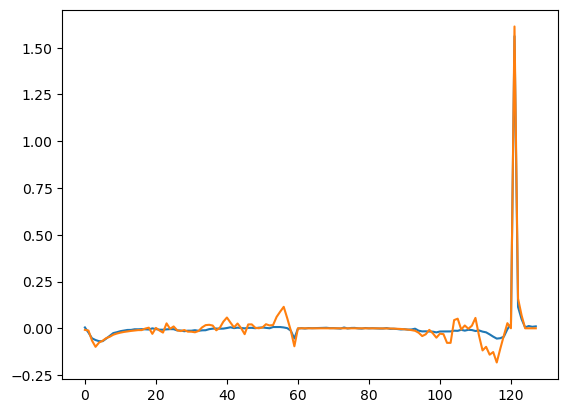

In [9]:
plt.plot(test_pred[0,:])
plt.plot(y_test[0,:])

/tmp/ipykernel_47720/70279493.py:16: RuntimeWarning: divide by zero encountered in divide
  R2_test_ptend_q0001_t = 1 - ((test_ptend_q0001_t - pred_ptend_q0001_t) ** 2).sum(0) / ((test_ptend_q0001_t - test_ptend_q0001_t.mean(0)) ** 2).sum(axis=0)


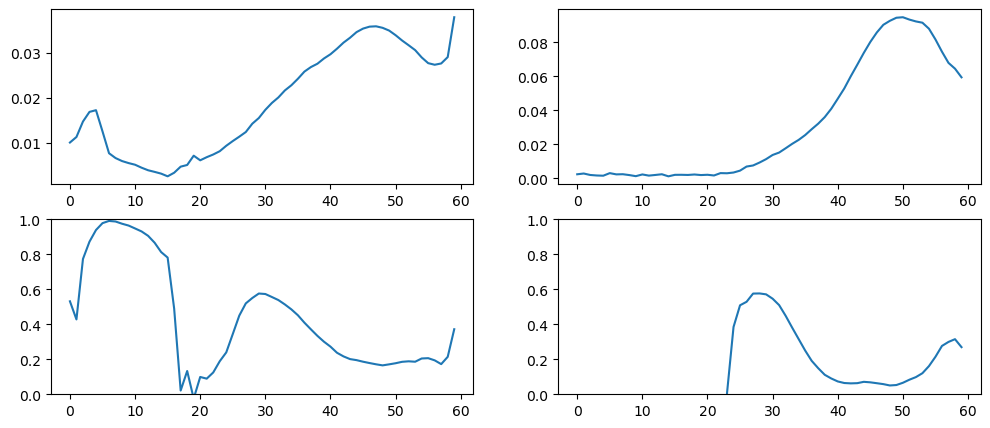

In [10]:
# Figure 2 in paper: error for different variables example: heating tendency

test_ptend_t = y_test[:,:60]
pred_ptend_t = test_pred[:,:60]
test_ptend_q0001_t = y_test[:,60:120]
pred_ptend_q0001_t = test_pred[:,60:120]

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(221)
# MAE
ax1.plot(np.mean(np.abs(test_ptend_t - pred_ptend_t), axis=0))
ax2 = fig.add_subplot(222)
ax2.plot(np.mean(np.abs(test_ptend_q0001_t - pred_ptend_q0001_t), axis=0))
# R2
R2_test_ptend_t = 1 - ((test_ptend_t - pred_ptend_t) ** 2).sum(0) / ((test_ptend_t - test_ptend_t.mean(0)) ** 2).sum(axis=0)
R2_test_ptend_q0001_t = 1 - ((test_ptend_q0001_t - pred_ptend_q0001_t) ** 2).sum(0) / ((test_ptend_q0001_t - test_ptend_q0001_t.mean(0)) ** 2).sum(axis=0)
ax3 = fig.add_subplot(223)
ax3.set_ylim(0,1)
ax3.plot(R2_test_ptend_t)
ax4 = fig.add_subplot(224)
ax4.set_ylim(0,1)
ax4.plot(R2_test_ptend_q0001_t)